In [1]:
import os
import sys
import flopy
import numpy as np
import pandas as pd
from osgeo import gdal

np.set_printoptions(threshold=sys.maxsize)

In [2]:
#import shapefile
import flopy.utils.binaryfile as bf
from flopy.utils.reference import SpatialReference
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
workspace = "workspace" #os.path.join("C:/Users/oscar.sanchez/PEST/CalibrationMF6")
if not os.path.exists(workspace):
    os.makedirs(workspace)
Insumos = "Insumos"
#workspace = "workspace"
name = "mf6model"
exe_name="mf6.exe"

In [4]:
### Loading raster layers for the 4 layer model

# Top layer:
PathTop = os.path.join(Insumos, "Superficie.tif")
demDs = gdal.Open(PathTop)
Superficie_Total = demDs.GetRasterBand(1).ReadAsArray()
geot = demDs.GetGeoTransform()

# Layer 1. Limos Rojos
Limos = os.path.join(Insumos, "EspLimos.tif")
demDsLimos = gdal.Open(Limos)
Espesor_Limos = demDsLimos.GetRasterBand(1).ReadAsArray()

# Layer 2. Gravoso
Gravoso = os.path.join(Insumos, "EspGravoso.tif")
demDsGravoso = gdal.Open(Gravoso)
Espesor_Gravoso = demDsGravoso.GetRasterBand(1).ReadAsArray()

# Layer 3. Finos
Finos = os.path.join(Insumos, "EspFinos.tif")
demDsFinos = gdal.Open(Finos)
Espesor_Finos = demDsFinos.GetRasterBand(1).ReadAsArray()

# Layer 4. Órganos
Organos = os.path.join(Insumos, "EspOrganos.tif")
demDsOrganos = gdal.Open(Organos)
Espesor_Organos = demDsOrganos.GetRasterBand(1).ReadAsArray()

# heads raster Capa 2: Gravoso
headPath_2 = os.path.join(Insumos, "Carga Hidráulica.tif")
headDs_2 = gdal.Open(headPath_2)
headData_2 = headDs_2.GetRasterBand(1).ReadAsArray()
#headData_2[headData_2 < 0] = 0

# heads raster Capa 4: Órganos
headPath_4 =  os.path.join(Insumos,"Carga_Organos.tif")
headDs_4 = gdal.Open(headPath_4)
headData_4 = headDs_4.GetRasterBand(1).ReadAsArray()
#headData_4[headData_4 < 0] = 0

### River stage and bottom rasters
RiverPathStage =  os.path.join(Insumos, "Rios_CortadoStage.tif")
demRiverStage = gdal.Open(RiverPathStage)
RiverStage = demRiverStage.GetRasterBand(1).ReadAsArray()
#RiverStage[RiverStage < 0] = 0

RiverPathBottom =  os.path.join(Insumos, "Rios_CortadoBottom.tif")
demRiverBottom = gdal.Open(RiverPathBottom)
RiverBottom = demRiverBottom.GetRasterBand(1).ReadAsArray()
#RiverBottom[RiverBottom < 0] = 0

In [5]:
### Initial condition of the model
# Spatial Reference Module
xll, yll = 1098000, 1271000 # model origin
xul, yul = 1098000, 1285000 
# Pixel size
delr = int(geot[1])
delc = int(abs(geot[5]))
# num of layers, num of cols an rows
nlay = 4
ncol = demDs.RasterXSize
nrow = demDs.RasterYSize
rot = 0

In [6]:
# Specify coordinate system
sr = flopy.utils.SpatialReference(delr=(np.ones(nrow, dtype=float) * delr),
                                  delc=(np.ones(nrow, dtype=float) * delc), lenuni=2,
                                  xul=xul, yul=yul, rotation=0, epsg='3116')
sr

xul:1098000; yul:1285000; rotation:0; proj4_str:+proj=tmerc +lat_0=4.596200416666666 +lon_0=-74.07750791666666 +k=1 +x_0=1000000 +y_0=1000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs ; units:meters; lenuni:2; length_multiplier:1.0

In [7]:
# Thicknes of all 4 layers as a vector
Espesores = [Espesor_Limos, Espesor_Gravoso, Espesor_Finos, Espesor_Organos]

In [8]:
# Top layer raster
ztop = Superficie_Total

# Subtracting top layer to the thickness of each layer to get the bottom
zbot = np.zeros((nlay, nrow, ncol), dtype=np.float32)

zbot[0,:,:] = ztop - Espesores[0]
for lay in range(1,nlay):
    zbot[lay,:,:] = zbot[lay-1,:,:] - Espesores[lay]  

### Graphic representation of rasters for each layer

In [9]:
# Model Extent
xmin = xll
xmax = 1110000
ymin = yll
ymax = 1285000
extent = (xmin, xmax , ymin, ymax)
x = np.arange(xmin, ymax, 50)
y = np.arange(xmin, ymax, 50)
X,Y= np.meshgrid(x,y)

<Figure size 432x288 with 0 Axes>

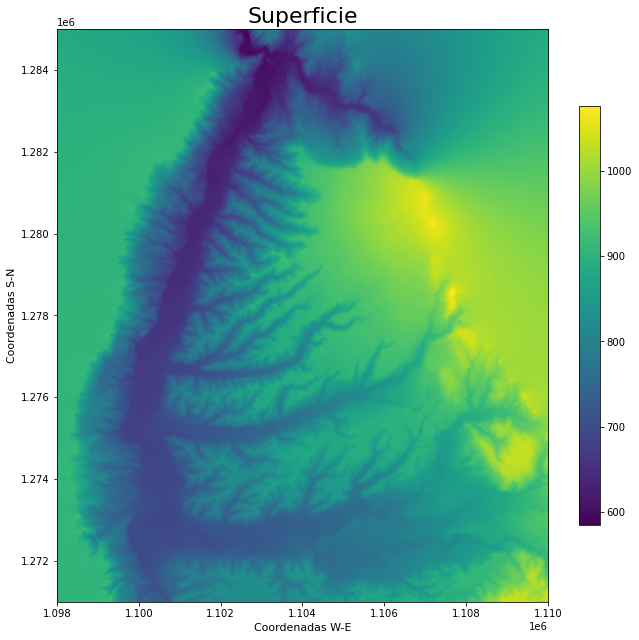

<Figure size 432x288 with 0 Axes>

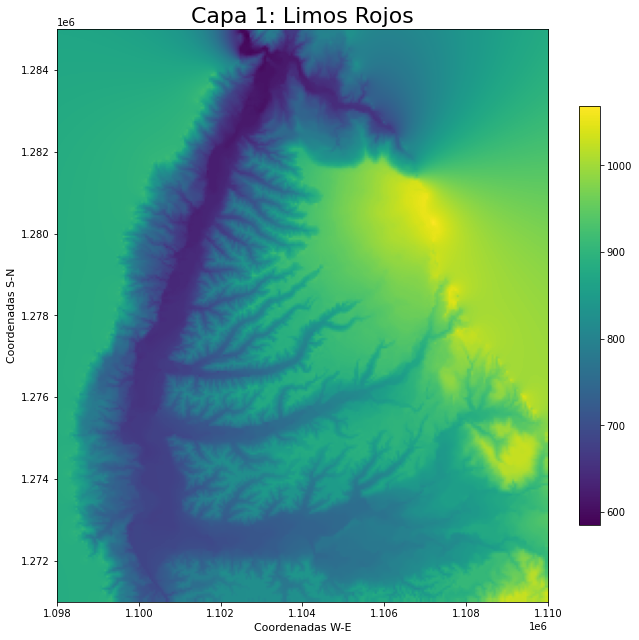

<Figure size 432x288 with 0 Axes>

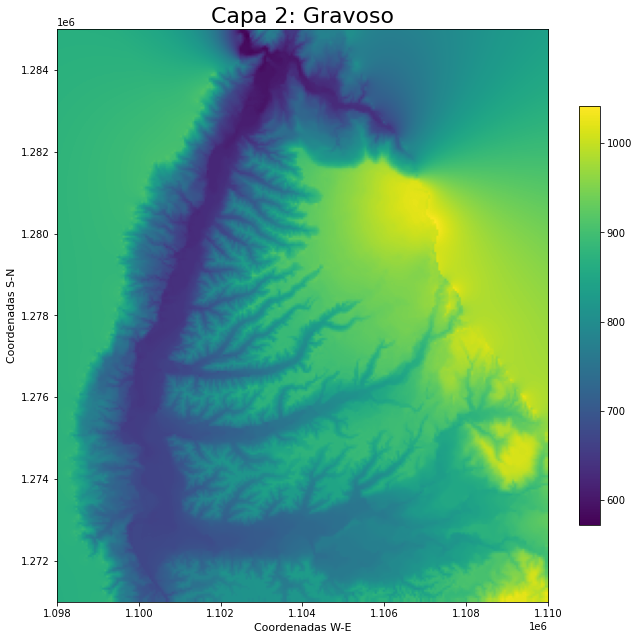

<Figure size 432x288 with 0 Axes>

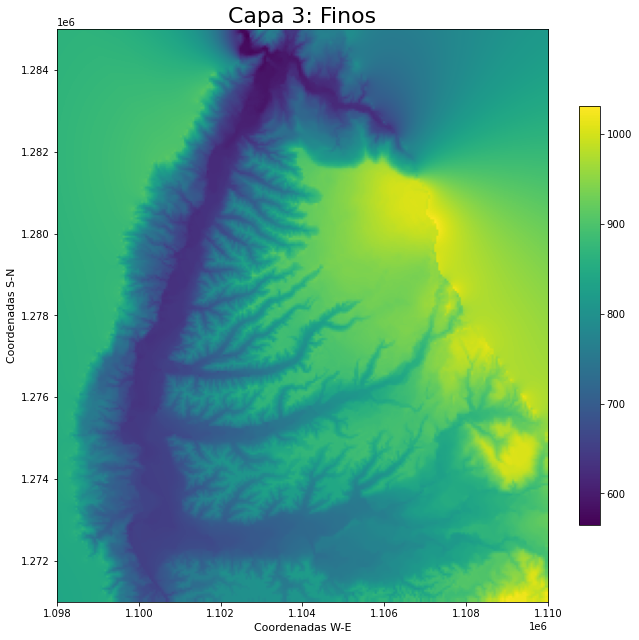

<Figure size 432x288 with 0 Axes>

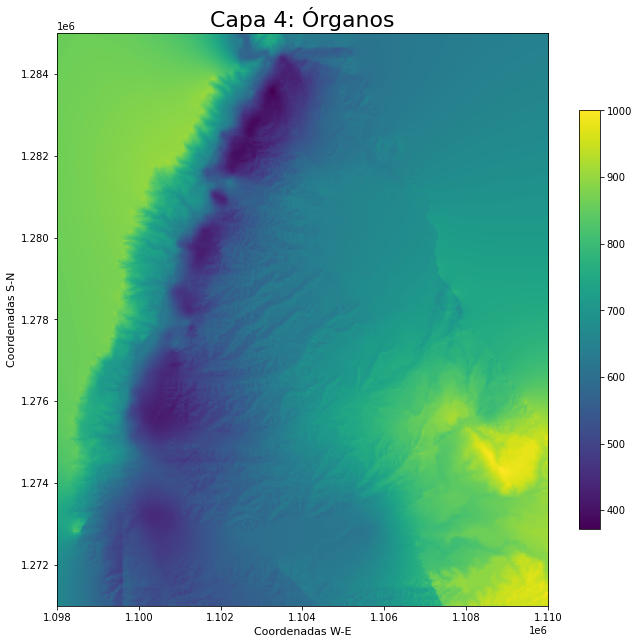

In [10]:
# TOP of the model
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
#zbot[0][zbot[0]>1.0e+38]=0    #These are no data values
#zbot[0][zbot[0]<-1.0e+38]=0   #These are no data values

plt.imshow(ztop,extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Superficie',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Superficie del terreno - ztop')

# LIMOS ROJOS LAYER 1
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow(zbot[0],extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Capa 1: Limos Rojos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Bottom de Limos Rojos - zbot 1')

# GRAVOSO LAYER 2
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
#zbot[1][zbot[1]>1.0e+38]=0
#zbot[1][zbot[1]<-1.0e+38]=0

plt.imshow(zbot[1],extent = extent)
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Capa 2: Gravoso',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Bottom de Gravoso - zbot 2')

# FINOS LAYER 3
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow(zbot[2],extent = extent)
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Capa 3: Finos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Bottom de Finos - zbot 3')


# ÓRGANOS LAYER 4
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow(zbot[3],extent = extent)
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Capa 4: Órganos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Bottom de Órganos - zbot 4')

<Figure size 432x288 with 0 Axes>

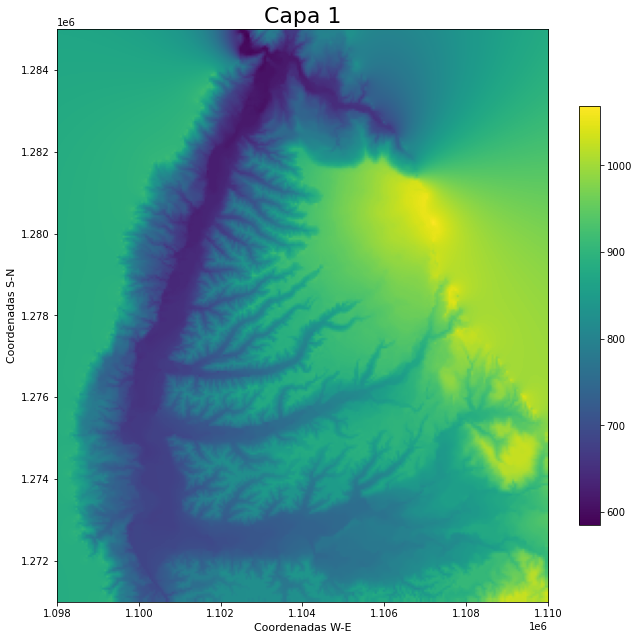

<Figure size 432x288 with 0 Axes>

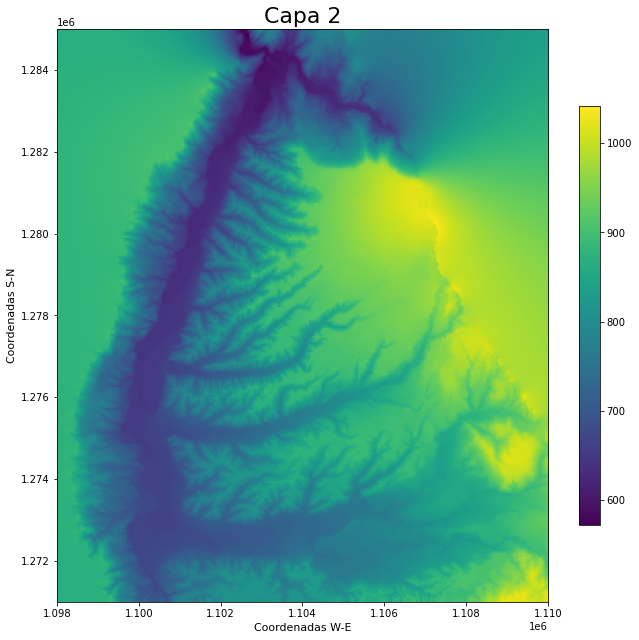

<Figure size 432x288 with 0 Axes>

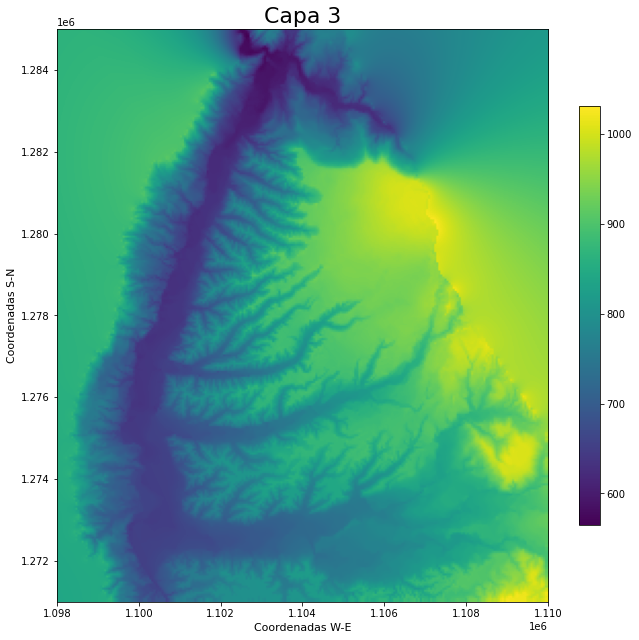

<Figure size 432x288 with 0 Axes>

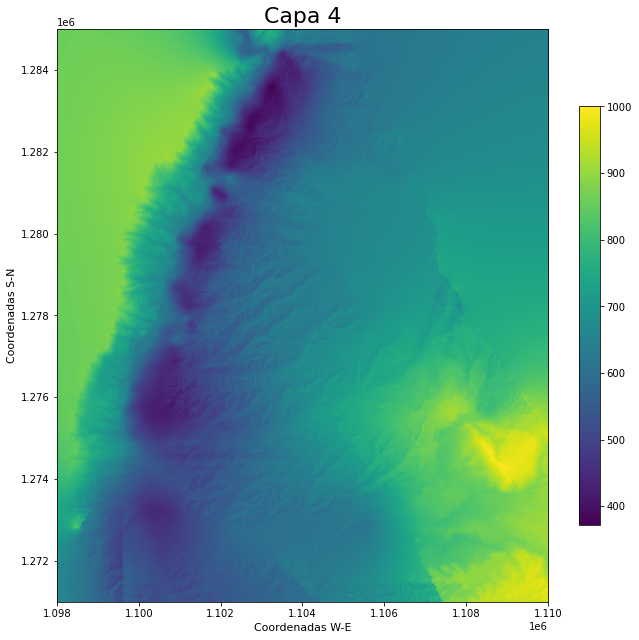

In [11]:
for ilay in range(4):  
    plt.figure()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
    plt.imshow((zbot[ilay]),extent = extent) 
    
    plt.xlabel('Coordenadas W-E',fontsize=11)
    plt.ylabel('Coordenadas S-N',fontsize=11)
    plt.title('Capa {}'.format(ilay + 1),fontsize = 22)
    plt.colorbar(shrink=0.7,ax=ax);
    #plt.savefig(fname='Capa {}'.format(ilay + 1))
   #ax = axes[ilay]
   #ax.set_title('Layer {}'.format(ilay + 1))
   #ax.set_aspect('equal')
   #modelmap = flopy.plot.PlotMapView(model=gwf, layer=ilay, ax=ax)

### Model domain for each of the four layers

In [12]:
# To have model domain we're using other raster with values > 0 only inside their domain (and not on every cell like the previous rasters)
# Top layer:
Path_Top = os.path.join(Insumos,"Espesor Limos.tif")
dem_Ds = gdal.Open(Path_Top)
FormaSuperficie = dem_Ds.GetRasterBand(1).ReadAsArray()
#FormaSuperficie[FormaSuperficie<0]=0

# Layer 1. Limos Rojos
_Limos = os.path.join(Insumos,"Espesor Limos.tif")
demDs_Limos = gdal.Open(_Limos)
FormaLimos = demDs_Limos.GetRasterBand(1).ReadAsArray()
#FormaLimos[FormaLimos<0]=0

# Layer 2. Gravoso
_Gravoso = os.path.join(Insumos,"Espesor Gravoso.tif")
demDs_Gravoso = gdal.Open(_Gravoso)
FormaGravoso = demDs_Gravoso.GetRasterBand(1).ReadAsArray()
#FormaGravoso[FormaGravoso<0]=0

# Layer 3. Finos
_Finos = os.path.join(Insumos,"Espesor Finos.tif")
demDs_Finos = gdal.Open(_Finos)
FormaFinos = demDs_Finos.GetRasterBand(1).ReadAsArray()
#FormaFinos[FormaFinos<0]=0

# Layer 4. Órganos
_Organos = os.path.join(Insumos,"Espesor Organos.tif")
demDs_Organos = gdal.Open(_Organos)
FormaOrganos = demDs_Organos.GetRasterBand(1).ReadAsArray()
#FormaOrganos[FormaOrganos<0]=0


In [13]:
# Each of these layers as a vector
Formas = [FormaLimos, FormaGravoso, FormaFinos, FormaOrganos]

In [14]:
# Se señalan las fronteras de cada capa

idomain = np.zeros((nlay, nrow, ncol), dtype=np.float32)
#idomain[0,:,:] = 1

for lay in range(1,nlay):
    idomain[lay][Formas[lay] <= 0] = 0 #-1e+38 and 1e+38 are no data values
    idomain[lay][Formas[lay] > 0] = 1

idomain[0,:,:] = idomain[2]

idomain[0][idomain[3] == -1] = 0
idomain[1][idomain[3] == -1] = 0
idomain[2][idomain[3] == -1] = 0
idomain[3][idomain[3] == -1] = 0

In [15]:
# Initial constant head
# Starting heads 
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:,:,:] = ztop

### Celdas activas e inactivas en cada capa

<Figure size 432x288 with 0 Axes>

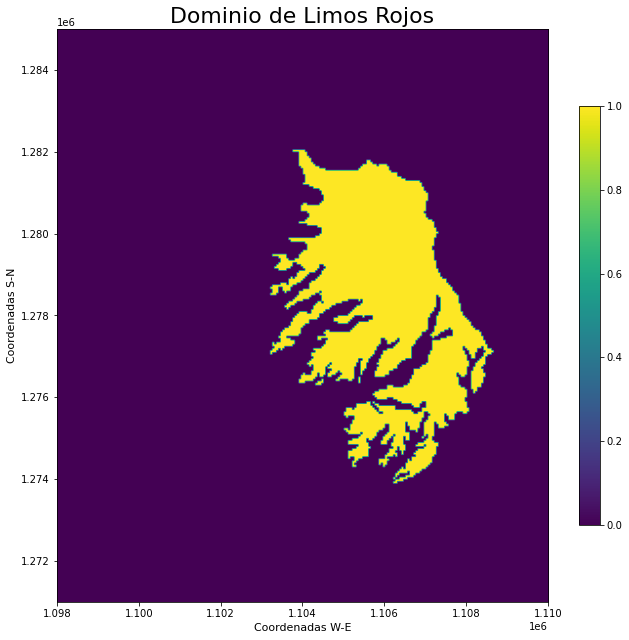

<Figure size 432x288 with 0 Axes>

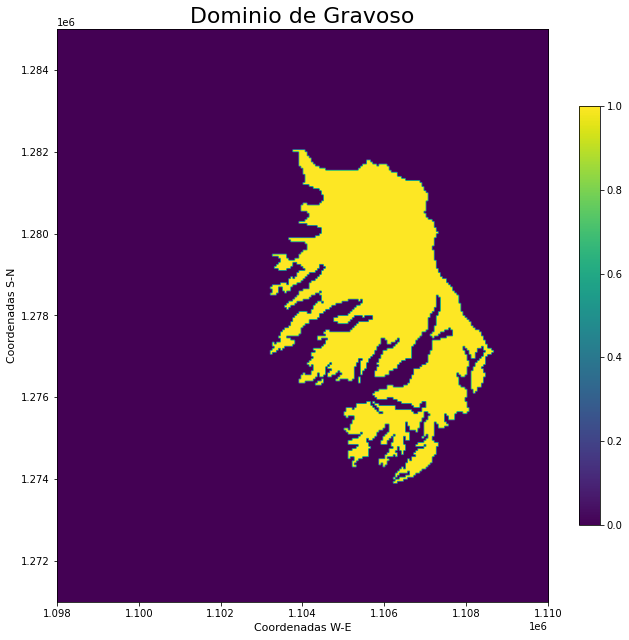

<Figure size 432x288 with 0 Axes>

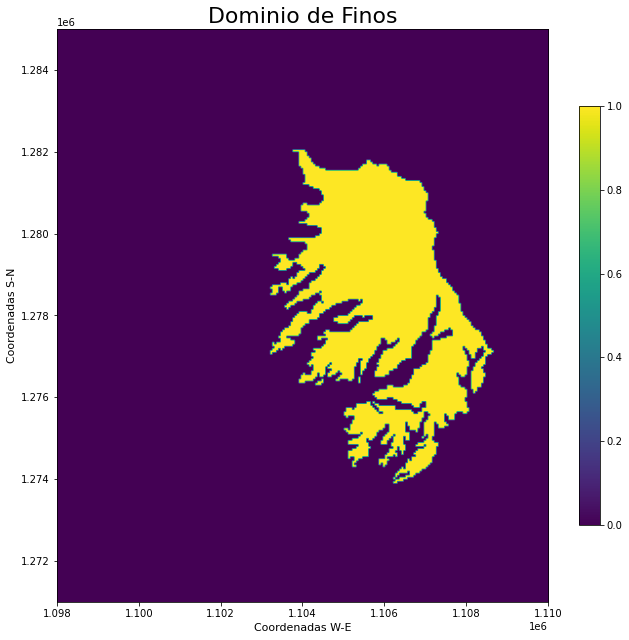

<Figure size 432x288 with 0 Axes>

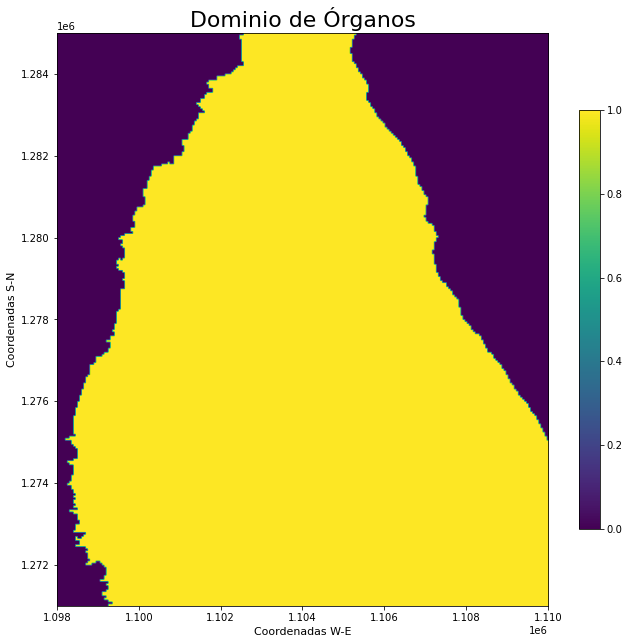

In [16]:
# CELDAS ACTIVAS: Dominio de la capa 1: Limos Rojos
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow(idomain[0],extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Dominio de Limos Rojos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Dominio de la capa 1 - Limos Rojos')

# CELDAS ACTIVAS/INACTIVAS. Dominio de la capa 2: Gravoso
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow(idomain[1],extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Dominio de Gravoso',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Dominio de la capa 2 - Gravoso')

# CELDAS ACTIVAS/INACTIVAS: Dominio de la capa 3: Finos 
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow(idomain[2],extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Dominio de Finos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Dominio de la capa 3 - Finos')

# CELDAS ACTIVAS/INACTIVAS: Dominio de la capa 4: Órganos
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow(idomain[3],extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Dominio de Órganos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Dominio de la capa 4 - Órganos')

In [17]:
# Horizontal hydraulic conductivity

kx0 = 1.1921e-4*np.ones([nrow,ncol])
# Hyraulic conductivy is modified on the layer 'Limos rojos'
# only where the domain equals -1 on the next layers below it 
kx0[idomain[0] == -1] = 1.1921e-4
kx0[idomain[1] == -1] = 1.1574e-7
kx0[idomain[2] == -1] = 4.167e-5
filnmkx0 = "hk0.txt"
np.savetxt(os.path.join(workspace,filnmkx0),kx0)

kx1 = 1.1921e-4*np.ones([nrow,ncol])
filnmkx1 = "hk1.txt"
np.savetxt(os.path.join(workspace,filnmkx1),kx1)

kx2 = 1.1574e-7*np.ones([nrow,ncol])
filnmkx2 = "hk2.txt"
np.savetxt(os.path.join(workspace,filnmkx2),kx2)

kx3 = 4.167e-5*np.ones([nrow,ncol])
filnmkx3 = "hk3.txt"
np.savetxt(os.path.join(workspace,filnmkx3),kx3)

kx=["hk0.txt","hk1.txt","hk2.txt","hk3.txt"]

# Vertical hydraulic conductivity

kz0 = 2.1991e-5*np.ones([nrow,ncol])
# Hyraulic conductivy is modified on the layer 'Limos rojos'
# only where the domain equals -1 on the next layers below it 
kz0[idomain[0] == -1] = 2.1991e-5
kz0[idomain[1] == -1] = 1.0417e-7
kz0[idomain[2] == -1] = 1.736e-6
filnmkz0 = "vk0.txt"
np.savetxt(os.path.join(workspace,filnmkz0),kz0)

kz1 = 2.1991e-5*np.ones([nrow,ncol])
filnmkz1 = "vk1.txt"
np.savetxt(os.path.join(workspace,filnmkz1),kz1)

kz2 = 1.0417e-7*np.ones([nrow,ncol])
filnmkz2 = "vk2.txt"
np.savetxt(os.path.join(workspace,filnmkz2),kz2)

kz3 = 1.736e-6*np.ones([nrow,ncol])
filnmkz3 = "vk3.txt"
np.savetxt(os.path.join(workspace,filnmkz3),kz3)

kz=["vk0.txt","vk1.txt","vk2.txt","vk3.txt"]

### Hydraulic conductivities graphic representation

### 1. Horizontal Conductivity

<Figure size 432x288 with 0 Axes>

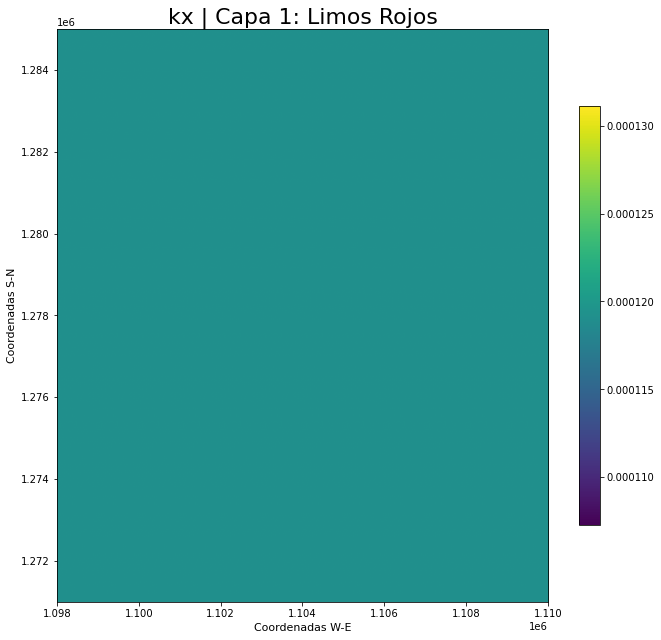

<Figure size 432x288 with 0 Axes>

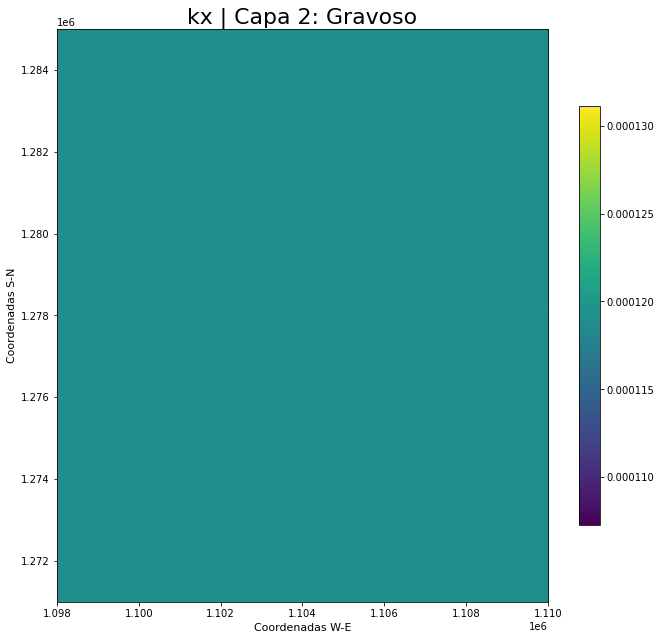

<Figure size 432x288 with 0 Axes>

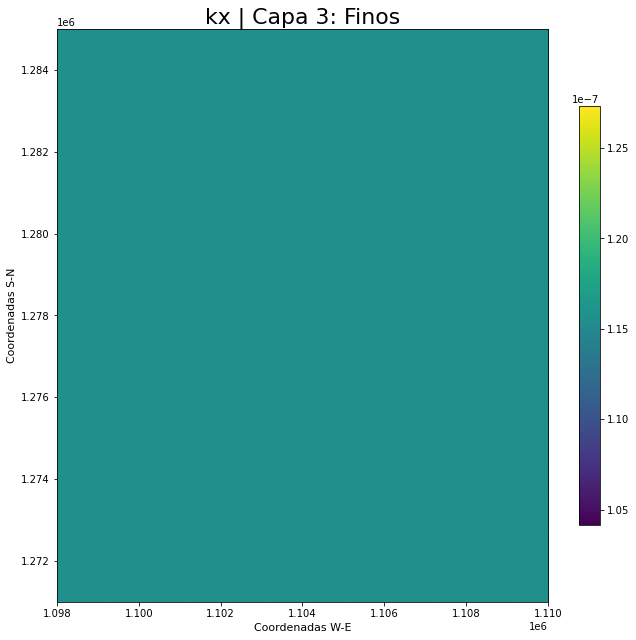

<Figure size 432x288 with 0 Axes>

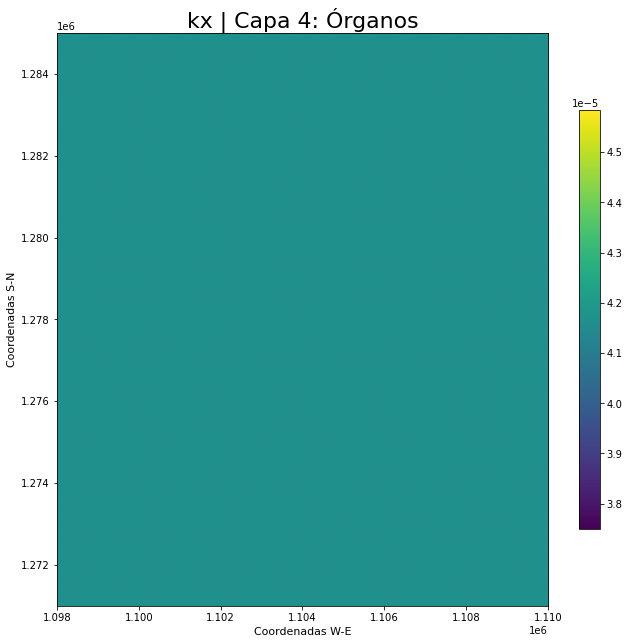

In [18]:
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kx0),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kx | Capa 1: Limos Rojos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kx de la capa 1 - Limos Rojos')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kx1),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kx | Capa 2: Gravoso',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kx de la capa 2 - Gravoso')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kx2),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kx | Capa 3: Finos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kx de la capa 3 - Finos')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kx3),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kx | Capa 4: Órganos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kx de la capa 4 - Órganos')

### 2. Vertical Conductivity kz

<Figure size 432x288 with 0 Axes>

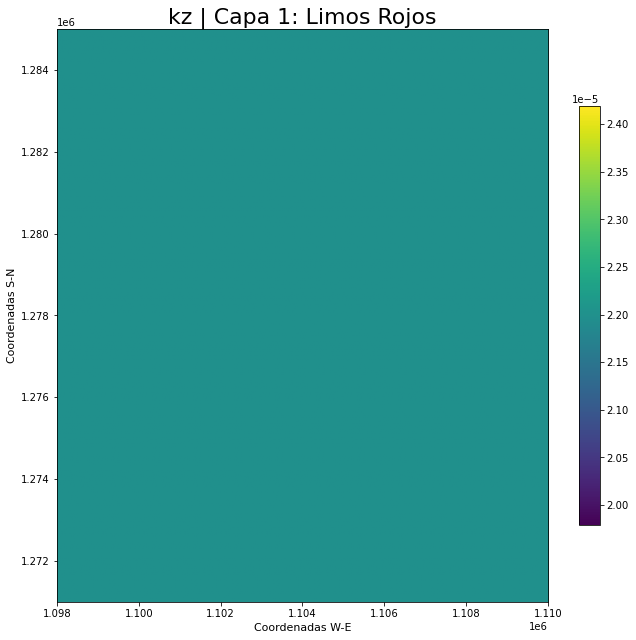

<Figure size 432x288 with 0 Axes>

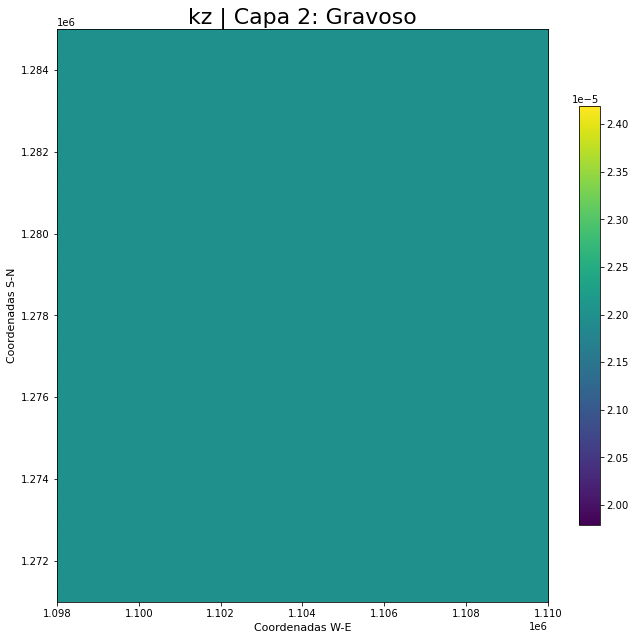

<Figure size 432x288 with 0 Axes>

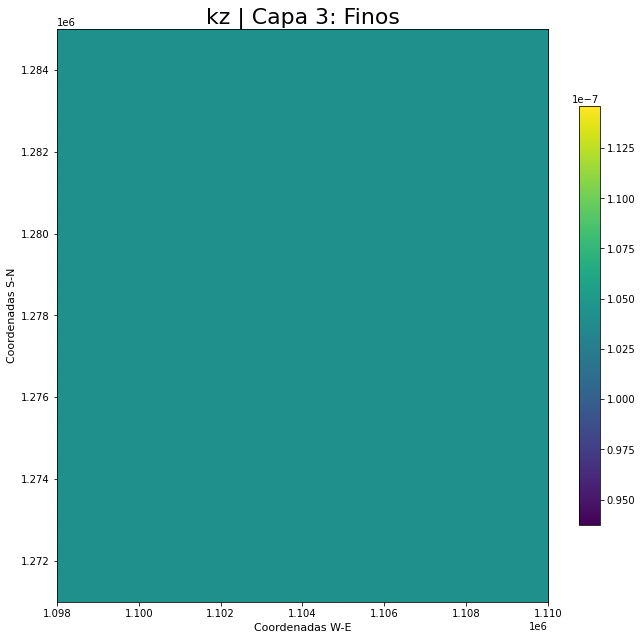

<Figure size 432x288 with 0 Axes>

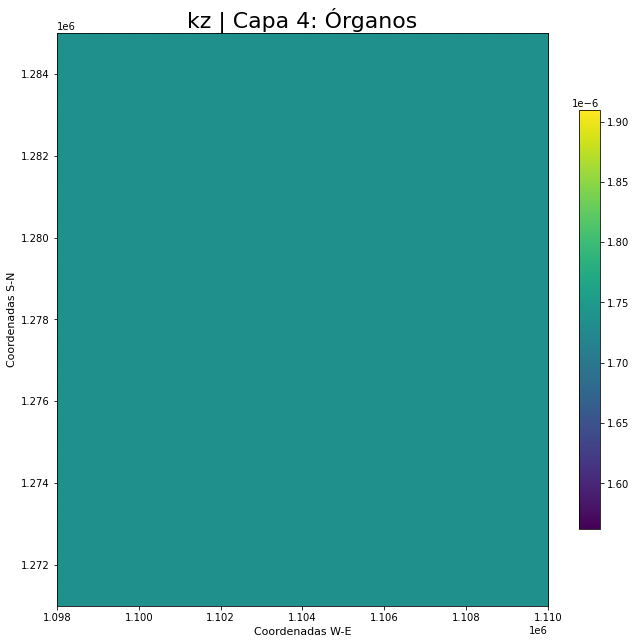

In [19]:
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kz0),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kz | Capa 1: Limos Rojos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kz de la capa 1 - Limos Rojos')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kz1),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kz | Capa 2: Gravoso',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kz de la capa 2 - Gravoso')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kz2),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kz | Capa 3: Finos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kz de la capa 3 - Finos')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kz3),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kz | Capa 4: Órganos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kz de la capa 4 - Órganos')

### Adding model river

In [20]:
# The raster contains real value numbers greater than zero in some cells of the array. 
# These are taken into account to create the stres_period_data 
# stressperioddata = (layer, row, col, stage, con., bottom)
river_values = np.column_stack(np.where(RiverStage > 0))
row = river_values[:, 0] #280
col = river_values[:, 1] #240

df_stage = pd.DataFrame(RiverStage)
stage = df_stage.to_numpy()[RiverStage > 0]

df_bottom = pd.DataFrame(RiverBottom)
bottom = df_bottom.to_numpy()[RiverBottom > 0]

In [21]:
# STRESS_PERIOD_DATA FOR RIVERS
spd_river_chd = [[(3, row[i], col[i]), stage[i]]for i in range(len(row))]

### Water Head - CHD Package

There are constant head values for layer 2 (Gravoso) and layer 4 (Órganos)

In [22]:
# Same here, we select real values that are greater than zero. But this time is just to plot
# stressperioddata = (layer, row, col, head)
# CAPA 2
f_chd_2 = np.column_stack(np.where(headData_2 > 0))
row_chd_2 = f_chd_2[:, 0] #280
col_chd_2 = f_chd_2[:, 1] #240

df_chd = pd.DataFrame(headData_2)
head_2 = df_chd.to_numpy()[headData_2 > 0].astype(float)

In [23]:
# Same here, we select real values that are greater than zero. But this time is just to plot
# stressperioddata = (layer, row, col, head)
# CAPA 4
f_chd_4 = np.column_stack(np.where(headData_4 > 0))
row_chd_4 = f_chd_4[:, 0] #280
col_chd_4 = f_chd_4[:, 1] #240

df_chd = pd.DataFrame(headData_4)
head_4 = df_chd.to_numpy()[headData_4 > 0].astype(float)

In [103]:
spd_chd_2 = [] #Gravoso
for m in range(len(row_chd_2)):
    spd_chd_2.append([(1, row_chd_2[m], col_chd_2[m]), head_2[m]])
    
spd_chd_4 = [] #Órganos
for m in range(len(row_chd_4)):
    spd_chd_4.append([(3, row_chd_4[m], col_chd_4[m]), head_4[m]])

In [124]:
list_spd_chd = spd_chd_2 + spd_chd_4 + spd_river_chd
lista=pd.DataFrame(list_spd_chd,columns=["celda","valor"])
print(lista)
lista.drop_duplicates(subset="celda",keep="first",inplace=True)
print(lista)
list_spd_chd2=lista.values.tolist()
print(list_spd_chd)


# pd.unique(list_spd_chd)

# list_spd_chd2=[]
# indices=[]
# a=np.array(list_spd_chd)

# for i in list_spd_chd:
# #     print(i)
# #     print(i[0])
#     indices.append((i[0][0],i[0][1],i[0][2]))
# #     print(indices)    
#     if (i[0][0],i[0][1],i[0][2]) not in list_spd_chd:
#         print("yes")
#         list_spd_chd2.append(i)
#     else:
#         print("no")
# # print(list_spd_chd2)
# print(list_spd_chd[:][:])

             celda        valor
0     (1, 74, 175)  1020.296000
1     (1, 75, 175)  1020.902000
2     (1, 75, 176)  1021.690000
3     (1, 76, 176)  1022.446000
4     (1, 76, 177)  1023.307000
...            ...          ...
3114  (3, 278, 52)   581.982422
3115  (3, 278, 53)   578.696533
3116  (3, 278, 54)   584.396423
3117  (3, 279, 53)   555.293701
3118  (3, 279, 54)   587.691772

[3119 rows x 2 columns]
             celda        valor
0     (1, 74, 175)  1020.296000
1     (1, 75, 175)  1020.902000
2     (1, 75, 176)  1021.690000
3     (1, 76, 176)  1022.446000
4     (1, 76, 177)  1023.307000
...            ...          ...
3114  (3, 278, 52)   581.982422
3115  (3, 278, 53)   578.696533
3116  (3, 278, 54)   584.396423
3117  (3, 279, 53)   555.293701
3118  (3, 279, 54)   587.691772

[3113 rows x 2 columns]
[[(1, 74, 175), 1020.296], [(1, 75, 175), 1020.902], [(1, 75, 176), 1021.69], [(1, 76, 176), 1022.446], [(1, 76, 177), 1023.307], [(1, 77, 177), 1024.229], [(1, 78, 177), 1025.053], 

### Head Observations - OBS Package

Same on layers 2 and 4. Observations are added in both layers as follows:

In [59]:
# Se carga el raster de observaciones
# Capa 2: Gravoso
pathobs = os.path.join(Insumos,"headsobs_layer2.tif")
headopenf = gdal.Open(pathobs)
headsobs_2 = headopenf.GetRasterBand(1).ReadAsArray()

#OBS
stackobs_2 = np.column_stack(np.where(headsobs_2 > 0))
row_obs_2 = stackobs_2[:, 0] #280
col_obs_2 = stackobs_2[:, 1] #240

dfobs_2 = pd.DataFrame(headsobs_2)
headobs_2 = dfobs_2.to_numpy()[headsobs_2 > 0]

In [60]:
# Se carga el raster de observaciones
# Capa 4: Órganos
pathobs = os.path.join(Insumos, "headsobs_layer4.tif")
headopenf = gdal.Open(pathobs)
headsobs_4 = headopenf.GetRasterBand(1).ReadAsArray()

#OBS
stackobs_4 = np.column_stack(np.where(headsobs_4 > 0))
row_obs_4 = stackobs_4[:, 0] #280
col_obs_4 = stackobs_4[:, 1] #240

dfobs_4 = pd.DataFrame(headsobs_4)
headobs_4 = dfobs_4.to_numpy()[headsobs_4 > 0]

In [61]:
obs_2 = [("{}_{}_{}".format(2, row_obs_2[i],col_obs_2[i]),
            "HEAD",
            (1, row_obs_2[i], col_obs_2[i])) for i in range(len(row_obs_2))]

obs_4 = [("{}_{}_{}".format(4, row_obs_4[i],col_obs_4[i]),
            "HEAD",
            (3, row_obs_4[i], col_obs_4[i])) for i in range(len(row_obs_4))]

In [62]:
obs = obs_2 + obs_4

In [63]:
obs_recarray = {('heads.csv'):obs}

### MF6 Packages and model execution

In [64]:
### Paquetes de Modflow 6

# Crear el paquete de simulación SIM
sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6', exe_name=exe_name, sim_ws=workspace)

# Crear el paquete de discretización temporal TDIS
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', nper=1, perioddata=[(1.0, 1, 1.0)])

# Crear el objeto GWF del modelo
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file='{}.nam'.format(name),version='mf6',exe_name=exe_name, print_flows=True,save_flows=True, newtonoptions=True)

# Crear el paquete de solucionador del modelo iterativo (IMS)
# Simple complexity; used for models not including stress or models either
# confined or w/ a single unconfined layer.
ims = flopy.mf6.ModflowIms(sim, print_option='ALL', pname='ims', complexity='COMPLEX', under_relaxation='DBD')

# Crear el paquete de discretización
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, delc=delc, delr=delr, top=ztop, botm=zbot, idomain=idomain, length_units='METERS', xorigin=xll, yorigin=yll, filename='{}.dis'.format(name))

# Create the initial conditions package IC (former BAS). STRT es la cabeza inicial al inicio de la simulación del modelo GWF. Debe ser especificado para todas las simulaciones incluso en estado permanente.
ic = flopy.mf6.ModflowGwfic(gwf, pname='ic', strt=strt)

In [65]:
# Crear el paquete node property flow (former LPF)
# icelltype: 1=Convertible 0=Confined -1=Unconfined
npf = flopy.mf6.ModflowGwfnpf(gwf, pname='npf', k=kx, k33=kz, icelltype =1, save_flows=True, save_specific_discharge=True)#, perched=True)

In [125]:
# STRESS_PERIOD_DATA FOR CONSTANT HEADS
##spd_chd = [[(1, row_chd[m], col_chd[m]), head[m]+10.] for m in range(len(row_chd))]
# Create constant head package
chd = flopy.mf6.ModflowGwfchd(gwf, pname='chd', save_flows=True, stress_period_data = list_spd_chd2)


In [126]:
# Create river package
# STRESS_PERIOD_DATA FOR RIVERS
# spd_river = [[(3, row[i], col[i]), stage[i], 1.157e-6, bottom[i]]for i in range(len(row))]
# river = flopy.mf6.ModflowGwfriv(gwf, pname='riv', save_flows=True, maxbound=len(row), stress_period_data = spd_river)

In [127]:
# OBS PACKAGE
obs_package = flopy.mf6.ModflowUtlobs(gwf,pname='head_obs',filename='{}.obs'.format(name), print_input=True,
                                         continuous=obs_recarray)

In [128]:
### Ejecución del modelo

#Output Control
oc   = flopy.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(name),
                            head_filerecord='{}.hds'.format(name),
                            saverecord=[('HEAD', 'ALL'), 
                                        ('BUDGET', 'ALL')],
                            printrecord=[('BUDGET', 'ALL')])
#Write the datasets
sim.write_simulation()

# RUN THE SIMULATION
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mf6model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 3113 based on size of stress_period_data
    writing package head_obs...
    writing package oc...
FloPy is using the following  executable to run the model: .\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 compiled Oct 22 2020 09:26:42 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis 

(False, [])

In [40]:
#list_spd_chd for m in range(len(row_chdO)+len(row_chd))

In [129]:
np.savetxt(os.path.join(workspace, 'mf6model.dis_idomain_layer0.txt'), idomain[0,:,:])
np.savetxt(os.path.join(workspace, 'mf6model.dis_idomain_layer1.txt'), idomain[1,:,:])
np.savetxt(os.path.join(workspace, 'mf6model.dis_idomain_layer2.txt'), idomain[2,:,:])
np.savetxt(os.path.join(workspace, 'mf6model.dis_idomain_layer3.txt'), idomain[3,:,:])

In [130]:
#np.savetxt(os.path.join(workspace, 'mf6model.npf_hk_layer0.txt'), kx[0,:,:])
#np.savetxt(os.path.join(workspace, 'mf6model.npf_hk_layer1.txt'), kx[1,:,:])
#np.savetxt(os.path.join(workspace, 'mf6model.npf_hk_layer2.txt'), kx[2,:,:])
#np.savetxt(os.path.join(workspace, 'mf6model.npf_hk_layer3.txt'), kx[3,:,:])

In [131]:
#np.savetxt(os.path.join(workspace, 'mf6model.npf_vk_layer0.txt'), kz[0,:,:])
#np.savetxt(os.path.join(workspace, 'mf6model.npf_vk_layer1.txt'), kz[1,:,:])
#np.savetxt(os.path.join(workspace, 'mf6model.npf_vk_layer2.txt'), kz[2,:,:])
#np.savetxt(os.path.join(workspace, 'mf6model.npf_vk_layer3.txt'), kz[3,:,:])

### Post Process

<Figure size 432x288 with 0 Axes>

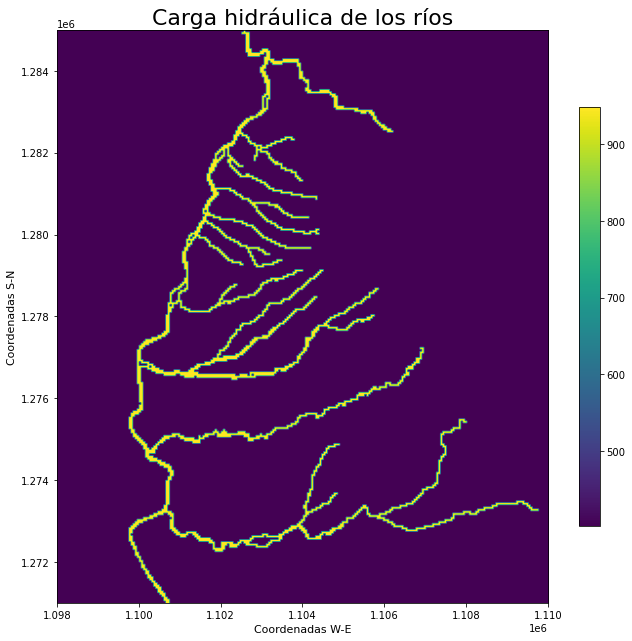

In [132]:
Map=RiverStage
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow(Map,extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Carga hidráulica de los ríos',fontsize = 22)
norm= mpl.colors.Normalize(vmin=abs(Map).min(), 
                           vmax=Map.max())
sm = plt.cm.ScalarMappable(norm=norm)
sm.set_array([])
fig.colorbar(sm, shrink=0.7);

In [133]:
# Se carga el archivo de carga hidráulica
dfcellhead=pd.read_csv(os.path.join(Insumos,'ConstantHead.csv'))

#row_chd = dfhead.values[:,0].astype(int) #280
#col_chd = dfhead.values[:,1].astype(int) #240
cellhead = dfcellhead.values[:,2].astype(float)

Text(0, 0.5, 'Coordenadas S-N')

<Figure size 432x288 with 0 Axes>

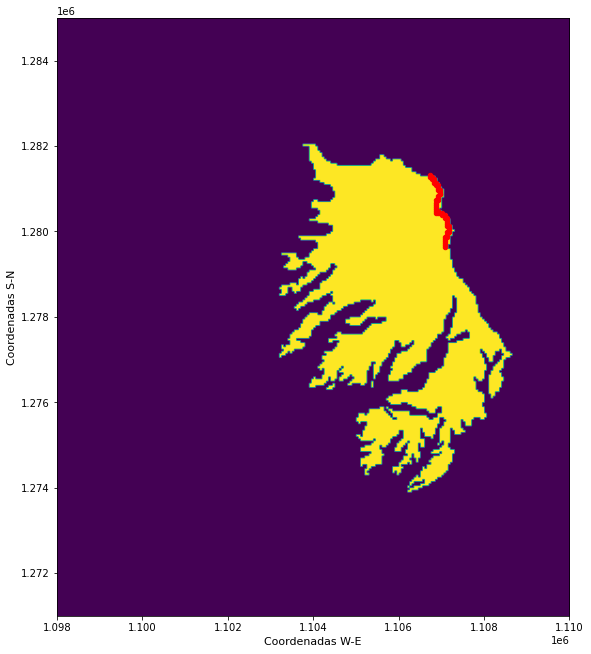

In [134]:
# Cabeza de agua, en la capa 2.
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

hdsx = [sr.xcentergrid[r-1,c-1] for r,c in dfcellhead.loc[:,["row","col"]].values]
hdsy = [sr.ycentergrid[r-1,c-1] for r,c in dfcellhead.loc[:,["row","col"]].values]
ax.scatter(hdsx,hdsy,marker='.', s=80,c='r')
plt.imshow(idomain[1], extent=extent)  

plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
#plt.title('Carga hidráulica constante | Capa 2: Gravoso',fontsize = 16)

#norm= mpl.colors.Normalize(vmin=head.min(), 
#                           vmax=head.max())
#sm = plt.cm.ScalarMappable(norm=norm)
#sm.set_array([])
#fig.colorbar(sm, shrink=0.7);
#plt.savefig(fname='Carga hidráulica cte en la capa 2')

In [135]:
#Extracción de resultados obtenidos de carga hidráulica
mfheads = flopy.utils.HeadFile(os.path.join(workspace,'mf6model.hds'))
times = mfheads.get_times() 
head = mfheads.get_data()

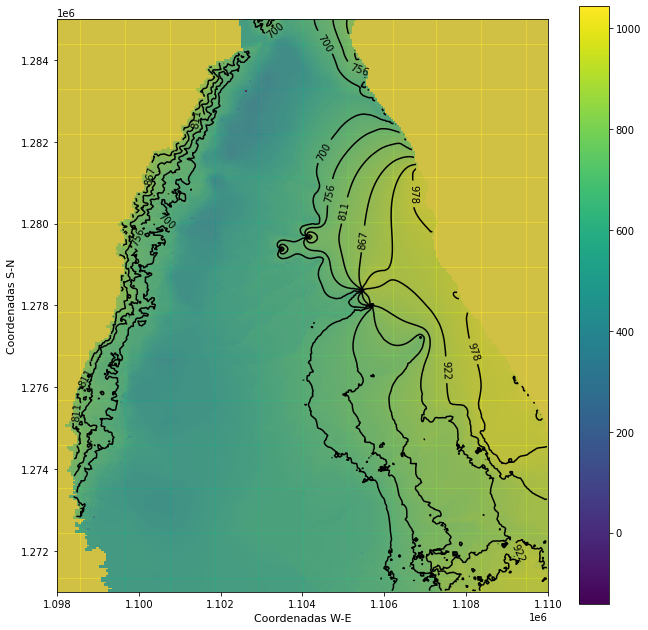

In [136]:
#Plotting head results for any layer (ilay)
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ilay=3

modelmap = flopy.plot.PlotMapView(model=gwf, layer=ilay)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head[ilay])
linecollection = modelmap.plot_grid(linewidth=0.4)
hmesh= modelmap.plot_array(head[ilay],masked_values=[-1e30,1e30],cmap="viridis")
plt.colorbar(hmesh)
cont = modelmap.contour_array(head[ilay],masked_values=[-1e30,1e30],levels=np.linspace(700,1200,10),colors="black")
plt.clabel(cont,fmt="%1.0f")


plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('',fontsize = 22);
#plt.savefig(fname='Carga hidráulica cte en la capa 4')

In [137]:
# Load binary grid file
fname = os.path.join(workspace, name + '.dis.grb')

# load the heads and budget files
fname = os.path.join(workspace, name + '.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()

fname = os.path.join(workspace, name + '.cbc')
cbb = flopy.utils.CellBudgetFile(fname, precision='double')
spdis = cbb.get_data(text='DATA-SPDIS')[0]
#qx = spdis['qx'].reshape(nlay,nrow,ncol)
#qy = spdis['qy'].reshape(nlay, nrow, ncol)
#qz = spdis['qz'].reshape(nlay, nrow, ncol)

AttributeError: 'NoneType' object has no attribute 'parent'

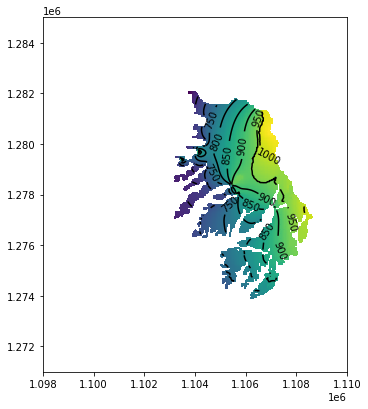

In [144]:

fig = plt.figure(figsize=(18,15))
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#teración para cada capa
for layer in range(4):
    ax  = fig.add_subplot(2,2,layer+1, aspect='equal')
    ml = flopy.plot.PlotMapView(model=gwf,layer=layer)
    hmesh=ml.plot_array(head[layer],masked_values=[-1e30,1e30],cmap="viridis")
    #hmesh.set_clim(0,10)
    
    #plot contour
    cont = ml.contour_array(head[layer],masked_values=[-1e30,1e30],levels=np.linspace(600,1050,10),colors="black",cmap="viridis")
    plt.clabel(cont,fmt="%1i")  
   
    #plot bc 
    ml.plot_bc("riv", color="cyan")
    ml.plot_bc("chd",color="cyan",alpha=0.5)
    
    #set labels
    plt.title("layer {}".format(layer))
    plt.colorbar(hmesh)
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")    

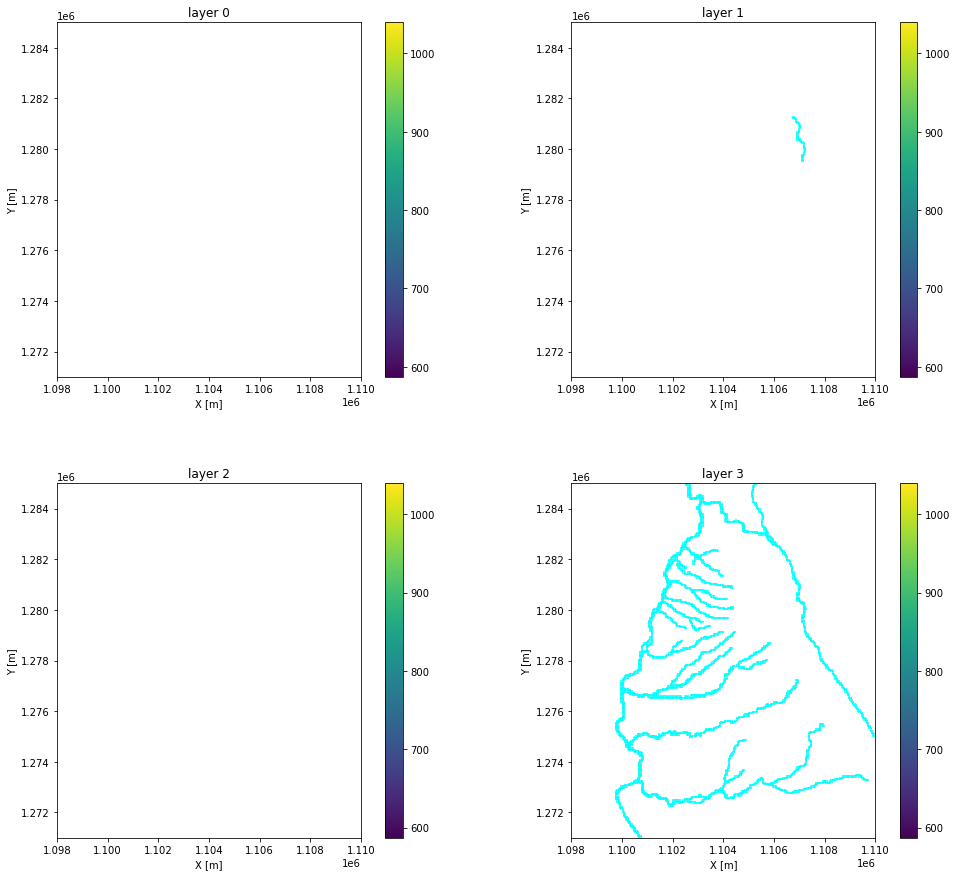

In [145]:
fig = plt.figure(figsize=(18,15))
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#iteración para cada capa
for layer in range(4):
    ax  = fig.add_subplot(2,2,layer+1, aspect='equal')
    
    
    #plot contour
    x = np.linspace(0, 12000, 240)
    y = np.linspace(0, 14000, 280)
    y = y[::-1]
    X, Y = np.meshgrid(x, y)
    c = plt.contour(X, Y, head[layer])

    dy, dx = np.gradient(-head[layer])
    ax.streamplot(X, Y, dx, dy, density=1.1, color='0.8')
    plt.clabel(c, fmt='%2.1f')
  
    #plot bc
    ml = flopy.plot.PlotMapView(model=gwf,layer=layer)
#     ml.plot_bc("riv", color="cyan")
    ml.plot_bc("chd",color="cyan",alpha=0.5)
    
    #set labels
    plt.title("layer {}".format(layer))
    plt.colorbar(hmesh)
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]") 

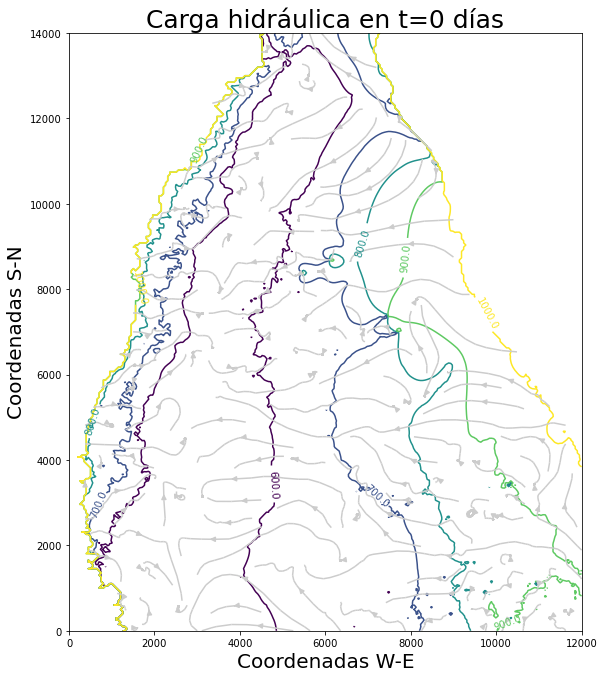

In [140]:
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

layer=3


x = np.linspace(0, 12000, 240)
y = np.linspace(0, 14000, 280)
y = y[::-1]

X, Y = np.meshgrid(x, y)
c = plt.contour(X,Y, head[layer], np.arange(600,1100,100))

dy, dx = np.gradient(-head[layer])

ax.streamplot(X, Y, dx,dy, density=1.1, color='0.8')

plt.clabel(c, fmt='%2.1f')

plt.xlabel('Coordenadas W-E',fontsize=20)
plt.ylabel('Coordenadas S-N',fontsize=20)
plt.title('Carga hidráulica en t=0 días',fontsize = 25)

plt.axis('scaled');

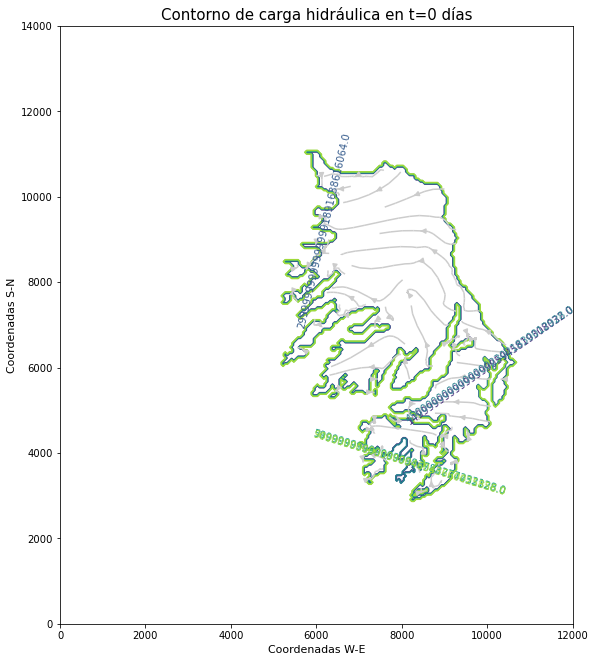

In [141]:
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

layer=0

x = np.linspace(0, 12000, 240)
y = np.linspace(0, 14000, 280)
y = y[::-1]

X, Y = np.meshgrid(x, y)
c = plt.contour(X, Y, head[layer])

dy, dx = np.gradient(-head[layer])
ax.streamplot(X, Y, dx, dy, density=1.5, color='0.8')

plt.clabel(c, fmt='%2.1f')

plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Contorno de carga hidráulica en t=0 días',fontsize = 15)

plt.axis('scaled');

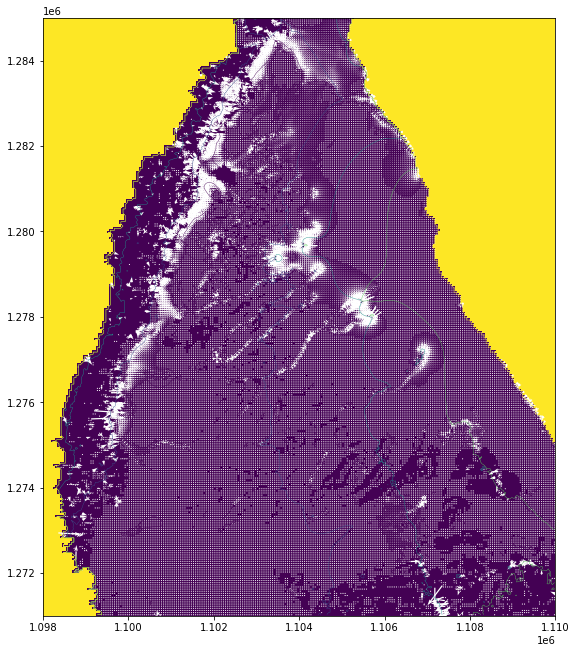

In [142]:
fig = plt.figure(figsize=(11,11))
fig.subplots_adjust(wspace=1,hspace=1)
pmv = flopy.plot.PlotMapView(gwf, layer=3)
pmv.plot_array(head)
#pmv.plot_grid()
pmv.contour_array(head,levels=np.linspace(500,1050,5), linewidths=.4)
pmv.plot_specific_discharge(spdis, color='white')

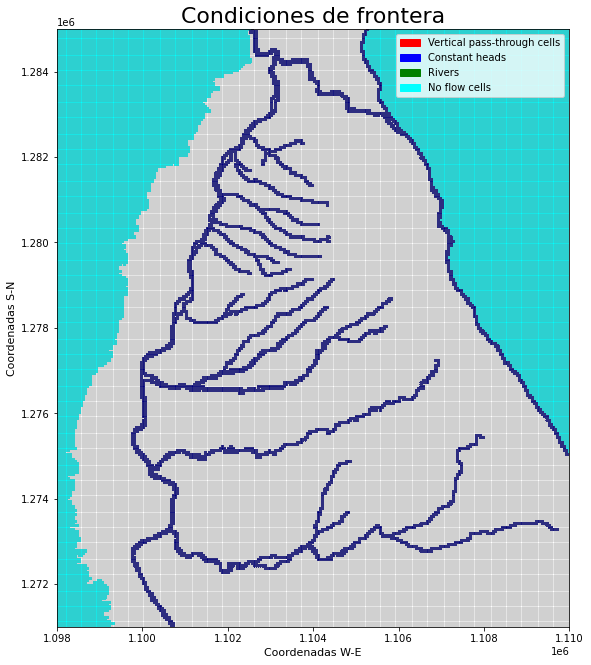

In [149]:
import matplotlib.patches as mpatches
gwf.modelgrid.set_coord_info(xoff=xmin, yoff=ymin, angrot=0, epsg=3116)
fig = plt.figure(figsize=(11, 11))

ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=gwf, layer=3)
#ch: constant heads
#vpt: vertical pass through cells
quadmesh = modelmap.plot_ibound(color_noflow='cyan', color_ch='blue', color_vpt='red')
# quadmesh = modelmap.plot_bc('riv', color='green')
quadmesh = modelmap.plot_bc('chd')

plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)

plt.title('Condiciones de frontera',fontsize = 22)
redpatch = mpatches.Patch(color='red', label='Vertical pass-through cells')
bluepatch = mpatches.Patch(color='blue', label='Constant heads')
greenpatch = mpatches.Patch(color='green', label='Rivers')
cyanpatch = mpatches.Patch(color='cyan', label='No flow cells')
plt.legend(handles=[redpatch, bluepatch, greenpatch, cyanpatch])

linecollection = modelmap.plot_grid(linewidth=0.4)

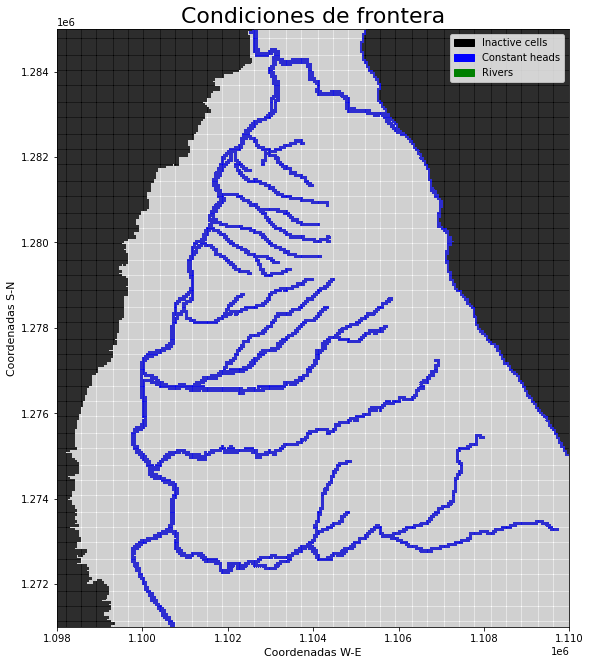

In [151]:
gwf.modelgrid.set_coord_info(xoff=xmin, yoff=ymin, angrot=0, epsg=3116)

fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=gwf, layer=3);
# RIV = modelmap.plot_bc('RIV', label  = 'Rivers', color = 'green', plotAll=True)
GHB = modelmap.plot_bc('CHD', label  = 'General head', color = 'blue', plotAll=True)
modelmap.plot_inactive()

plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)

plt.title('Condiciones de frontera',fontsize = 22)
blackpatch = mpatches.Patch(color='black', label='Inactive cells')
bluepatch = mpatches.Patch(color='blue', label='Constant heads')
greenpatch = mpatches.Patch(color='green', label='Rivers')
plt.legend(handles=[blackpatch, bluepatch, greenpatch])

linecollection = modelmap.plot_grid(linewidth=0.4);

<Figure size 432x288 with 0 Axes>

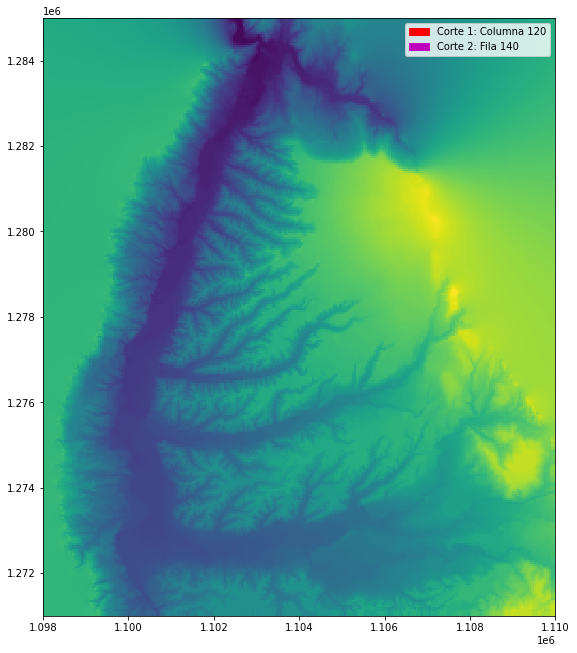

In [152]:
gwf.modelgrid.set_coord_info(xoff=xmin, yoff=ymin, angrot=0, epsg=3116)
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

x1, y1 = [0,12000], [7000, 7000]
x2, y2 = [6000, 6000], [0, 14000]
corteh = plt.plot(x1, y1, color='m', linestyle='--', lw=3)
cortev = plt.plot(x2, y2, color='r', linestyle='--', lw=3)
red_patch = mpatches.Patch(color='red', label='Corte 1: Columna 120')
mag_patch = mpatches.Patch(color='m', label='Corte 2: Fila 140')
plt.legend(handles=[red_patch,mag_patch])

pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=0)

pmv.plot_array(ztop);

In [ ]:
#fig = plt.figure(figsize=(25,15))
#ax = fig.add_subplot(1, 1, 1)
#modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'column': 120})
#linecollection = modelxsect.plot_grid()
#plt.gca().invert_xaxis()
#plt.xlabel('Coordenadas W-E',fontsize=20)
#plt.ylabel('Altura [m]',fontsize=20)
#
#plt.legend(handles=[red_patch], prop={'size': 15})
#plt.title('Sección transversal con conductividad hidráulica horizontal',fontsize = 25)
#
#modelxsect.plot_array(kx0);
##kx[:,0,0]

In [ ]:
#fig = plt.figure(figsize=(25,15))
#ax = fig.add_subplot(1, 1, 1)
#modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'row': 140})
#linecollection = modelxsect.plot_grid()
#plt.gca().invert_xaxis()
#plt.xlabel('Coordenadas W-E',fontsize=20)
#plt.ylabel('Altura [m]',fontsize=20)
#
#plt.legend(handles=[mag_patch], prop={'size': 15})
#plt.title('Sección transversal con conductividad hidráulica vertical',fontsize = 25)
#
#modelxsect.plot_array(kz);
#kz[:,0,0]

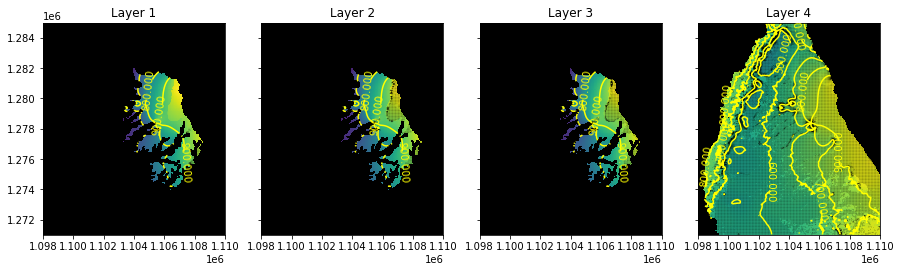

In [153]:
fpth = workspace + '/{}.hds'.format(name)
hobj = flopy.utils.HeadFile(fpth)
kstpkper = hobj.get_kstpkper()
dpos = kstpkper[0]
h = hobj.get_data(kstpkper=dpos)

fpth = workspace + '/{}.cbc'.format(name)
cobj = flopy.utils.CellBudgetFile(fpth, precision='double')
ra = cobj.get_data(kstpkper=dpos, text='DATA-SPDIS')[0]

fig, axes = plt.subplots(ncols=nlay, nrows=1, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(15)
for k, ax in enumerate(axes.flatten()):
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=k)
    ax.set_title('Layer {}'.format(k+1))
    ax.set_aspect('equal')
    ax.set_xlim(0, 5000)
    ax.set_ylim(0, 10000)
    mm.plot_array(h, masked_values=[1e30, -1e30])
    c = mm.contour_array(h, masked_values=[1e30, -1e30], colors='yellow', 
                         levels=np.arange(500, 1000, 100))
    plt.clabel(c)
    mm.plot_ibound(ibound=np.array(idomain))
    mm.plot_specific_discharge(ra);

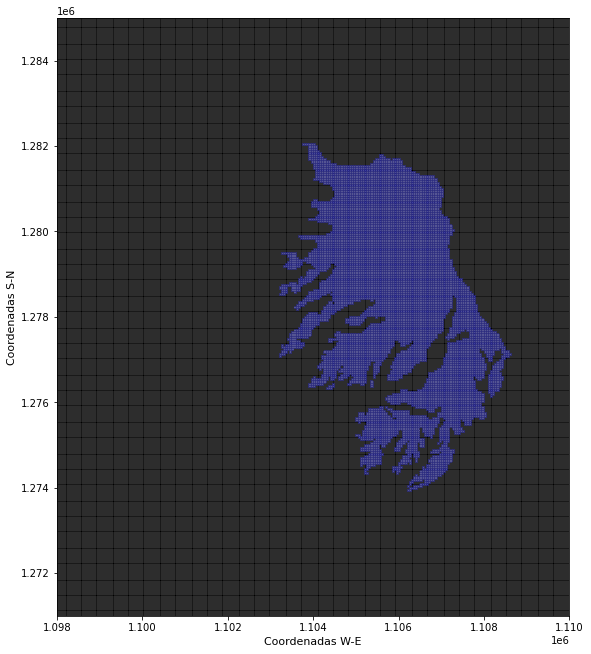

In [154]:
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

vmin = head.min()
vmax = head.max()

modelmap = flopy.plot.PlotMapView(model=gwf, layer=1)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head[1], masked_values=[1.0e30], alpha=0.5, 
                                   vmin=vmin, vmax=vmax, cmap='jet')
linecollection = modelmap.plot_grid(linewidth=0.4)

plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('',fontsize = 22);

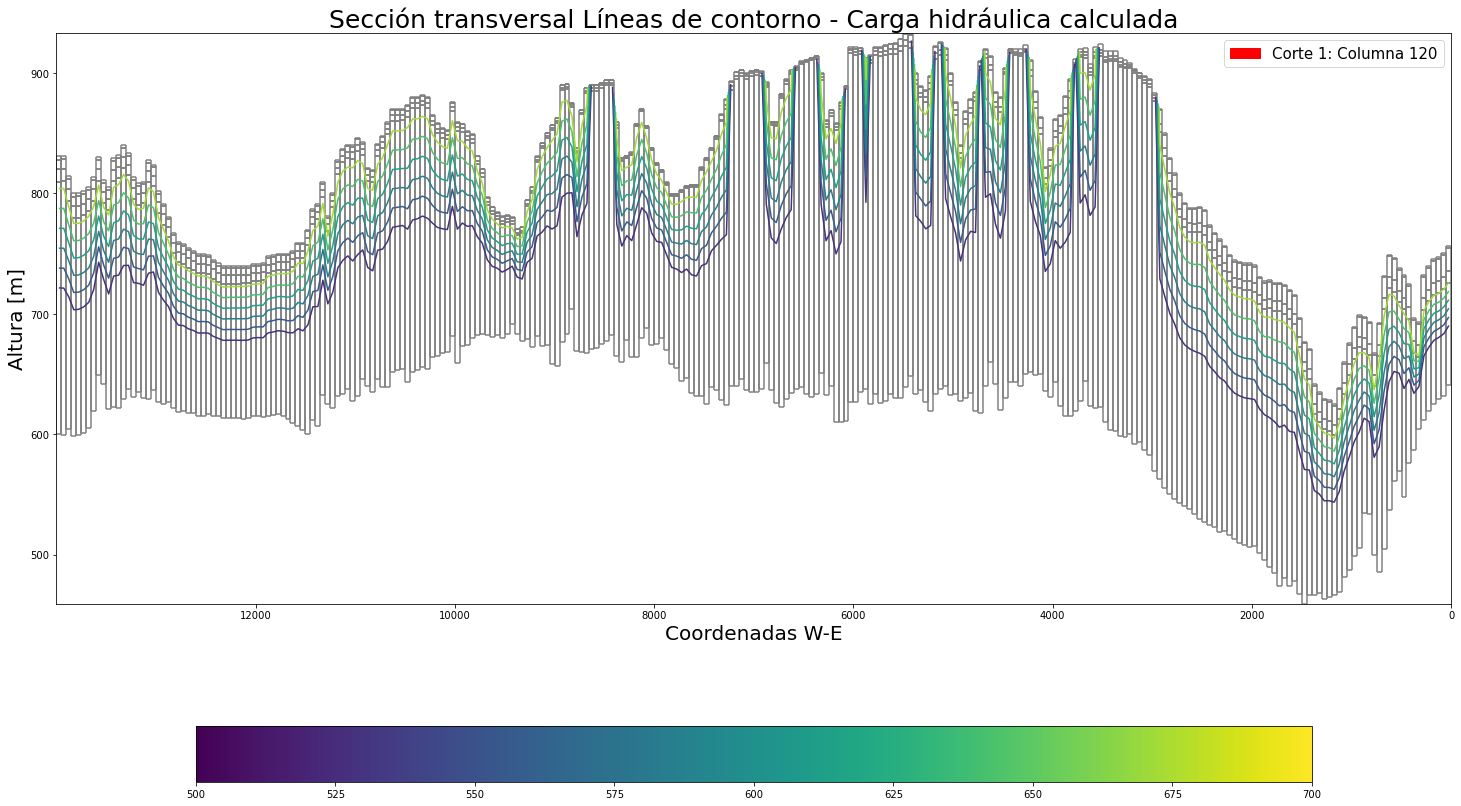

In [155]:
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'column': 120})
linecollection = modelxsect.plot_grid()
#linewidth=0.3

plt.gca().invert_xaxis()
plt.xlabel('Coordenadas W-E',fontsize=20)
plt.ylabel('Altura [m]',fontsize=20)
red_patch = mpatches.Patch(color='red', label='Corte 1: Columna 120')

plt.legend(handles=[red_patch], prop={'size': 15})
plt.title('Sección transversal Líneas de contorno - Carga hidráulica calculada',fontsize = 25)
#head_d[head_d<0]=0
#head_d[head_d>.5e+30]=0
headsmap = modelxsect.contour_array(head)
#plt.colorbar(headsmap, orientation='horizontal',shrink=0.8, extend='both')
norm= mpl.colors.Normalize(vmin=500, 
                           vmax=700)
sm = plt.cm.ScalarMappable(norm=norm, cmap=headsmap.cmap)
sm.set_array([])
fig.colorbar(sm, orientation='horizontal', shrink=0.8);

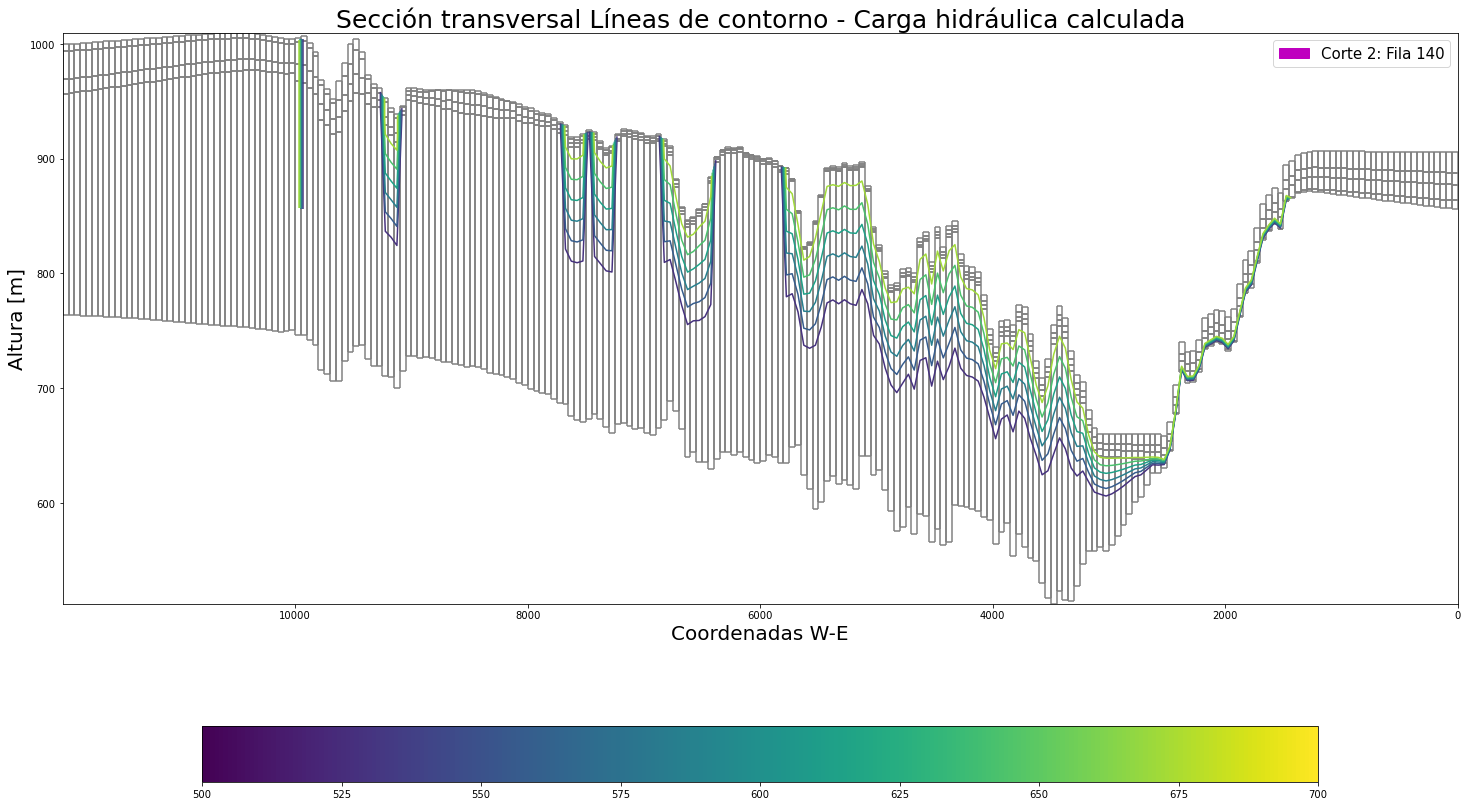

In [156]:
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'row': 140})
linecollection = modelxsect.plot_grid()

plt.gca().invert_xaxis()
plt.xlabel('Coordenadas W-E',fontsize=20)
plt.ylabel('Altura [m]',fontsize=20)

plt.legend(handles=[mag_patch], prop={'size': 15})
plt.title('Sección transversal Líneas de contorno - Carga hidráulica calculada',fontsize = 25)

headsmap=modelxsect.contour_array(head)
#vmin=headsmap.cvalues.min(), vmax=headsmap.cvalues.max())
norm= mpl.colors.Normalize(vmin=500, 
                           vmax=700)
sm = plt.cm.ScalarMappable(norm=norm, cmap=headsmap.cmap)
sm.set_array([])
fig.colorbar(sm, orientation='horizontal', shrink=0.8);

In [157]:

# load the heads and budget files
fname = os.path.join(workspace,'mf6model.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
times = hdobj.get_times()

fname = os.path.join(workspace, '{}.cbc'.format(name))
cbb = flopy.utils.binaryfile.CellBudgetFile(fname, precision='double')
cbb.list_records()

flowja = cbb.get_data(text='FLOW-JA-FACE', totim=times[0])[0][0,0,:]
#chdflow = cbb.get_data(text='CHD', totim=times[0])[0]

(1, 1, b'    FLOW-JA-FACE', 395562, 1, -1, 1, 1., 1., 1., b'', b'', b'', b'')
(1, 1, b'      DATA-SPDIS', 240, 280, -4, 6, 1., 1., 1., b'MF6MODEL        ', b'NPF             ', b'MF6MODEL        ', b'NPF             ')
(1, 1, b'             CHD', 240, 280, -4, 6, 1., 1., 1., b'MF6MODEL        ', b'MF6MODEL        ', b'MF6MODEL        ', b'CHD             ')


In [158]:
keys = sim.simulation_data.mfdata.output_keys()

('mf6model', 'CBC', 'FLOW-JA-FACE')
('mf6model', 'CBC', 'DATA-SPDIS')
('mf6model', 'CBC', 'CHD')
('mf6model', 'HDS', 'HEAD')


In [159]:
fname = os.path.join(workspace, '{}.cbc'.format(name))
cbb = flopy.utils.binaryfile.CellBudgetFile(fname, precision='double')
cbb.list_unique_records()

RECORD           IMETH
----------------------
FLOW-JA-FACE         1
DATA-SPDIS           6
CHD                  6


In [160]:
fname = os.path.join(workspace, '{}.dis.grb'.format(name))
bgf = flopy.utils.mfgrdfile.MfGrdFile(fname)
ia = bgf._datadict['IA'] - 1
ja = bgf._datadict['JA'] - 1

In [161]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(1,1,1,aspect='equal')
#
## get head data
#HEAD = sim.simulation_data.mfdata['mf6model', 'CBC', 'CHD']
#HEAD=HEAD[0]
#
#modelmap = flopy.plot.PlotMapView(model=gwf, layer=0)
#linecollection = modelmap.plot_grid(linewidth=0.4)
#cs = modelmap.plot_array(HEAD, cmap=plt.get_cmap('jet', 18))
#
#plt.colorbar(cs, shrink=0.5)
#plt.show()

In [162]:
#Data-spdis represents the components of specific discharge in the X, Y and Z directions
spd = cbb.get_data(text='DATA-SPDIS')[0]

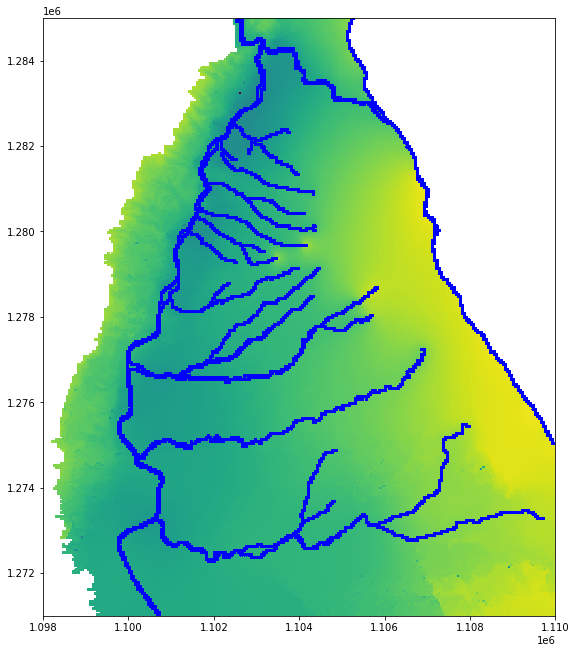

In [176]:
mm = flopy.plot.PlotMapView(model=gwf, layer=3)
mm.plot_array(head, masked_values=[1e30])
#
fig = plt.gcf()
fig.set_size_inches(11,11)
#
# mm.plot_bc('RIV', color='blue')
mm.plot_bc('CHD', color='blue')
#mm.plot_specific_discharge(spd)

#### Carga Hidráulica sin curvas

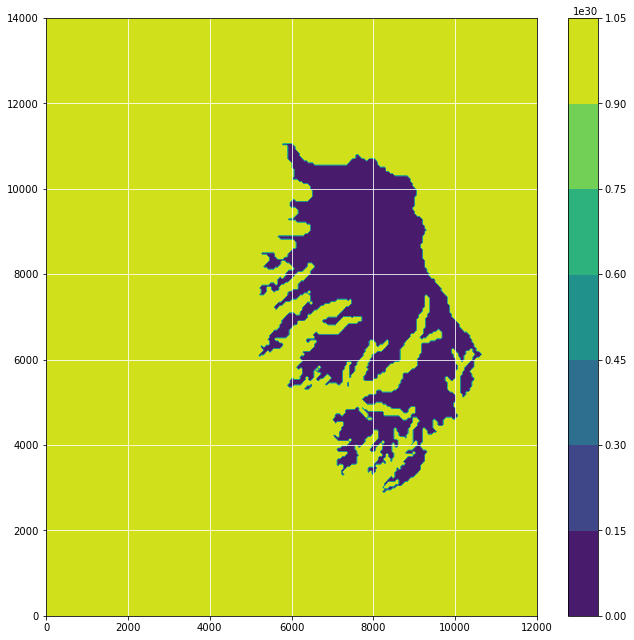

In [164]:
fig = plt.figure(figsize=(11,11))
fig.subplots_adjust(wspace=1,hspace=1)
plt.contourf(x, y, head[1,:,:])
plt.grid(True,color='w')
plt.title('')
plt.colorbar()
plt.subplots_adjust(wspace = 0.5,hspace=0.8)

In [165]:
##xcoord = np.linspace((delc/2), ncol*delc-(delc/2), ncol)
watertable = flopy.utils.postprocessing.get_water_table(head, nodata=1e30)
watertable[watertable>1e20]=0
##watertable[watertable==0]=float('nan')
#x = np.linspace(0, 12000, 240)
#plt.plot(x, watertable.T, 'k--');
#
#plt.gca().invert_xaxis();

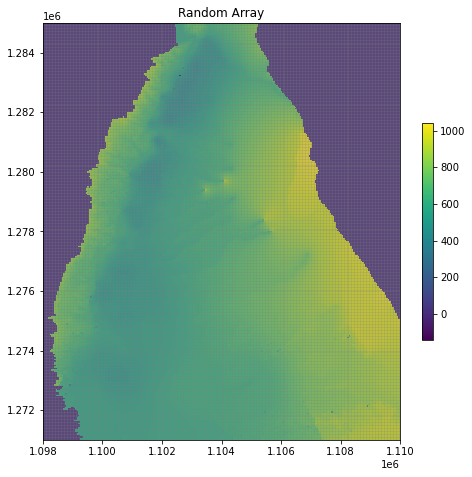

In [166]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Random Array')
mapview = flopy.plot.PlotMapView(model=gwf, layer=1)
quadmesh = mapview.plot_array(watertable)
linecollection = mapview.plot_grid(linewidth=0.4)
cb = plt.colorbar(quadmesh, shrink=0.5)

In [167]:
#fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15, 8))
#vmin = head.min()
#vmax = head.max()
#levels = np.linspace(vmin, vmax, 20)
#
#for ilay in range(nlay):
#    ax = axes[ilay]
#    ax.set_title('Layer {}'.format(ilay + 1))
#    ax.set_aspect('equal')
#    modelmap = flopy.plot.PlotMapView(model=m, layer=ilay, ax=ax)
#    quadmesh = modelmap.plot_array(head, masked_values=[0], alpha=0.5, 
#                                   vmin=vmin, vmax=vmax, cmap='jet')
#    linecollection = modelmap.plot_grid()
#    contour_set = modelmap.contour_array(head, levels=levels, colors='white')
#    quiver = modelmap.plot_discharge(frf, fff, head=head)
#cb = fig.colorbar(quadmesh, ax=axes, shrink=0.5)

In [168]:
#fig = plt.figure(figsize=(18, 5))
#ax = fig.add_subplot(1, 1, 1)
#xsect = flopy.plot.PlotCrossSection(model=gwf, line={'Row': 100})
#csa = xsect.plot_array(head[3].reshape(280,240))

In [169]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

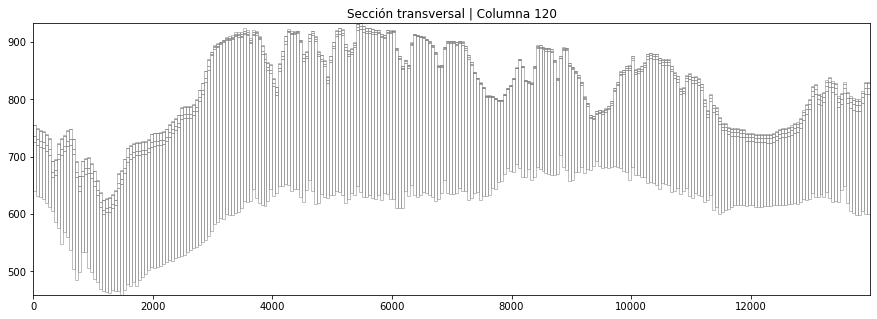

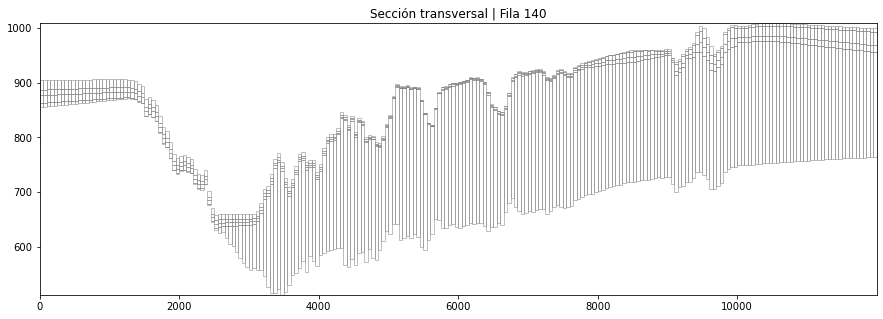

In [170]:
### Sección transversal en la mitad del modelo (columna 120)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=gwf, line={'column': 120})
#patches = xsect.plot_ibound(color_noflow='green')

linecollection = xsect.plot_grid(lw=0.5)
t = ax.set_title('Sección transversal | Columna 120')

### Sección transversal en la mitad del modelo (fila 140)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=gwf, line={'row': 140})
#patches = xsect.plot_ibound(color_noflow='green')

linecollection = xsect.plot_grid(lw=0.5)
t = ax.set_title('Sección transversal | Fila 140')

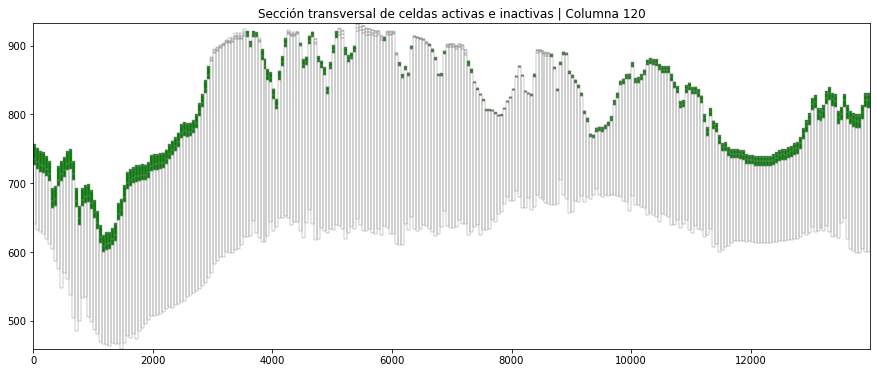

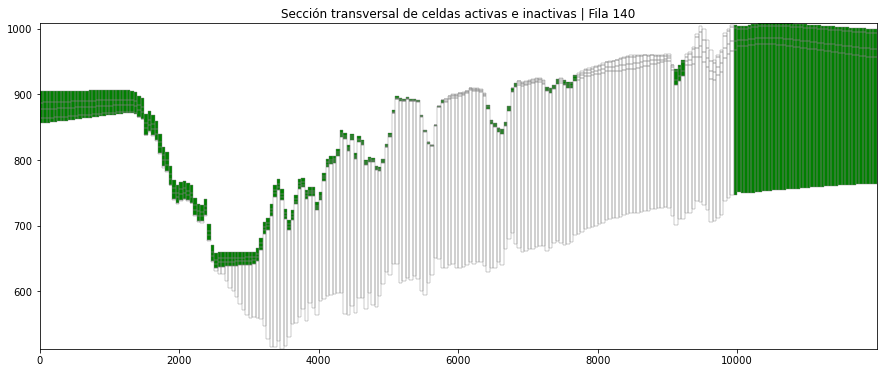

In [171]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'Column': 120})
patches = modelxsect.plot_ibound(color_noflow='green')
linecollection = modelxsect.plot_grid(linewidth=0.4)
t = ax.set_title('Sección transversal de celdas activas e inactivas | Columna 120')

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'Row': 140})
patches = modelxsect.plot_ibound(color_noflow='green')
linecollection = modelxsect.plot_grid(linewidth=0.4)
t = ax.set_title('Sección transversal de celdas activas e inactivas | Fila 140')

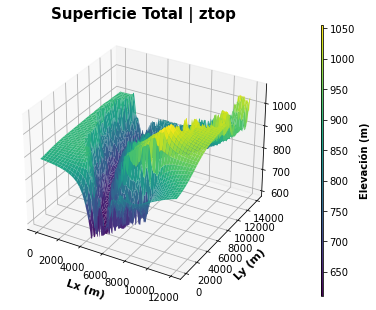

In [172]:
from mpl_toolkits.mplot3d import Axes3D
#Vista 3d ztop
#create 3d figure
fig_3d = plt.figure(figsize=(15,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot
X = np.arange(0,ncol*delc,delc)
Y = np.arange(0,nrow*delc,delr)
X, Y = np.meshgrid(X, Y)
Z = ztop

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf, shrink=1, aspect=150).set_label('Elevación (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=11, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=11, fontweight='bold')
ax.set_title('Superficie Total | ztop', fontsize=15, fontweight='bold')
plt.show(surf)

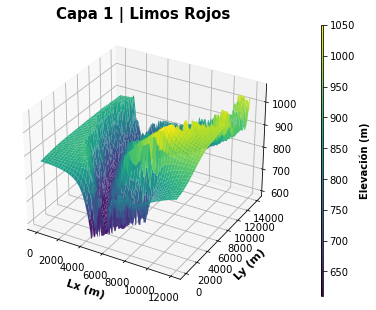

In [173]:
#Vista 3d ztop
#create 3d figure
fig_3d = plt.figure(figsize=(15,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot
X = np.arange(0,ncol*delc,delc)
Y = np.arange(0,nrow*delc,delr)
X, Y = np.meshgrid(X, Y)
Z = zbot[0]

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf, shrink=1, aspect=150).set_label('Elevación (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=11, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=11, fontweight='bold')
ax.set_title('Capa 1 | Limos Rojos', fontsize=15, fontweight='bold')
plt.show(surf)

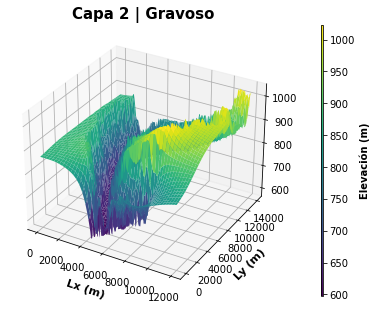

In [174]:
#Vista 3d ztop
#create 3d figure
fig_3d = plt.figure(figsize=(15,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot
X = np.arange(0,ncol*delc,delc)
Y = np.arange(0,nrow*delc,delr)
X, Y = np.meshgrid(X, Y)
Z = zbot[1]

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf, shrink=1, aspect=150).set_label('Elevación (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=11, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=11, fontweight='bold')
ax.set_title('Capa 2 | Gravoso', fontsize=15, fontweight='bold')
plt.show(surf)

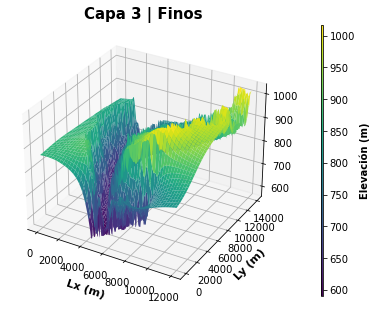

In [175]:
#Vista 3d ztop
#create 3d figure
fig_3d = plt.figure(figsize=(15,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot
X = np.arange(0,ncol*delc,delc)
Y = np.arange(0,nrow*delc,delr)
X, Y = np.meshgrid(X, Y)
Z = zbot[2]

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf, shrink=1, aspect=150).set_label('Elevación (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=11, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=11, fontweight='bold')
ax.set_title('Capa 3 | Finos', fontsize=15, fontweight='bold')
plt.show(surf)

In [ ]:
#Vista 3d ztop
#create 3d figure
fig_3d = plt.figure(figsize=(15,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot
X = np.arange(0,ncol*delc,delc)
Y = np.arange(0,nrow*delc,delr)
X, Y = np.meshgrid(X, Y)
Z = zbot[3]

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf, shrink=1, aspect=150).set_label('Elevación (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=11, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=11, fontweight='bold')
ax.set_title('Capa 4 | Órganos', fontsize=15, fontweight='bold')
plt.show(surf)

In [ ]:
pm = flopy.plot.PlotMapView(model=gwf, layer=3)
c = pm.plot_array(ztop)

In [ ]:
plt.imshow(zbot[0])
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

x = np.arange(20)
y = np.arange(20)
data = x[:-1,None]+y[None,:-1]

fig = plt.gcf()
ax = fig.add_subplot(111)

X,Y = np.meshgrid(x,y)
quadmesh = ax.pcolormesh(X,Y,data)
plt.colorbar(quadmesh)